In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product c.csv', parse_dates=['Month-Year'])

In [3]:
sales_c= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_c.shape

(60, 2)

In [5]:
sales_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_c['Sales'].sum()

45599092

In [7]:
sales_c = sales_c.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_c.head()

ds       y
0 2019-01-01  496334
1 2019-02-01  306455
2 2019-03-01  476270
3 2019-04-01  628463
4 2019-05-01  366750

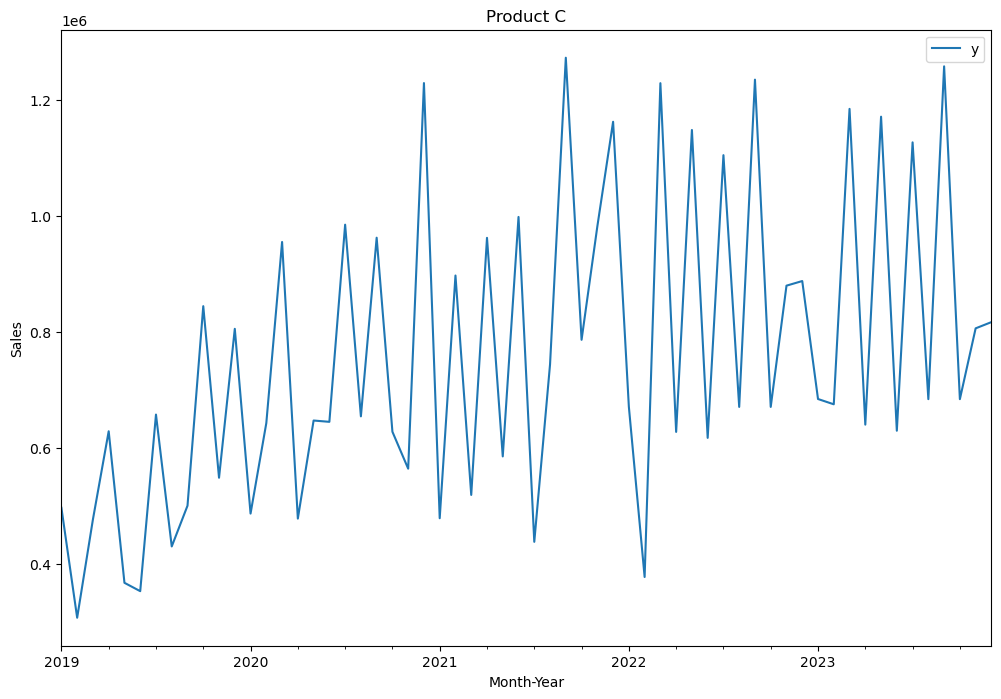

In [8]:
ax = sales_c.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product C')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_c['y'])

ADF Statistics: -2.8900034461607835
p- value: 0.04652287109563067
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [12]:
train= sales_c[:48]
test=sales_c[48:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:12 - cmdstanpy - INFO - Chain [1] done processing
23:30:16 - cmdstanpy - INFO - Chain [1] start processing
23:30:16 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:23 - cmdstanpy - INFO - Chain [1] start processing
23:30:23 - cmdstanpy - INFO - Chain [1] done processing
23:30:26 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing
23:30:31 - cmdstanpy - INFO - Chain [1] start processing
23:30:31 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing
23:30:37 - cmdstanpy - INFO - Chain [1] start processing
23:30:38 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:42 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   341162.359979  
1   347989.710530  
2   306984.827195  
3   345101.713167  
4   345231.344043  
.. 

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
26                    0.100                      0.1         additive   
2                     0.001                      0.1         additive   
62                    0.500                      0.1         additive   
14                    0.010                      0.1         additive   
38                    0.200                      0.1         additive   
..                      ...                      ...              ...   
33                    0.100                      5.0   multiplicative   
21                    0.010                      5.0   multiplicative   
35                    0.100                     10.0   multiplicative   
23                    0.010                     10.0   multiplicative   
11                    0.001                     10.0   multiplicative   

             rmse  
26  306386.354275  
2   306984.827195  
62  307262.440075  
14  307666.364381  
38  307671.976090  
..            ...  
33  373613.265591  
21  373998.871306  
35  375793.206659  
23  382727.301942  
11  394737.048446  

[72 rows x 4 columns]

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [16]:
# Create a Prophet model
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.1, seasonality_mode='additive',interval_width=0.95)

In [17]:
model.fit(train)

23:37:41 - cmdstanpy - INFO - Chain [1] start processing
23:37:41 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [19]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [20]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [21]:
forecasted_df

ds          yhat     yhat_lower    yhat_upper
48 2023-01-01  7.901947e+05  415379.521123  1.180145e+06
49 2023-02-01  8.151415e+05  450069.272852  1.167484e+06
50 2023-03-01  1.044079e+06  682412.142725  1.429838e+06
51 2023-04-01  9.288241e+05  563333.273974  1.294611e+06
52 2023-05-01  9.412238e+05  564739.308488  1.315088e+06
53 2023-06-01  9.066149e+05  535467.003899  1.277074e+06
54 2023-07-01  1.045073e+06  695448.510047  1.433039e+06
55 2023-08-01  8.818582e+05  513776.868300  1.257865e+06
56 2023-09-01  1.229615e+06  865845.302850  1.623383e+06
57 2023-10-01  9.838538e+05  632174.253033  1.356891e+06
58 2023-11-01  9.989307e+05  634554.995465  1.407828e+06
59 2023-12-01  1.257373e+06  888595.261123  1.600185e+06

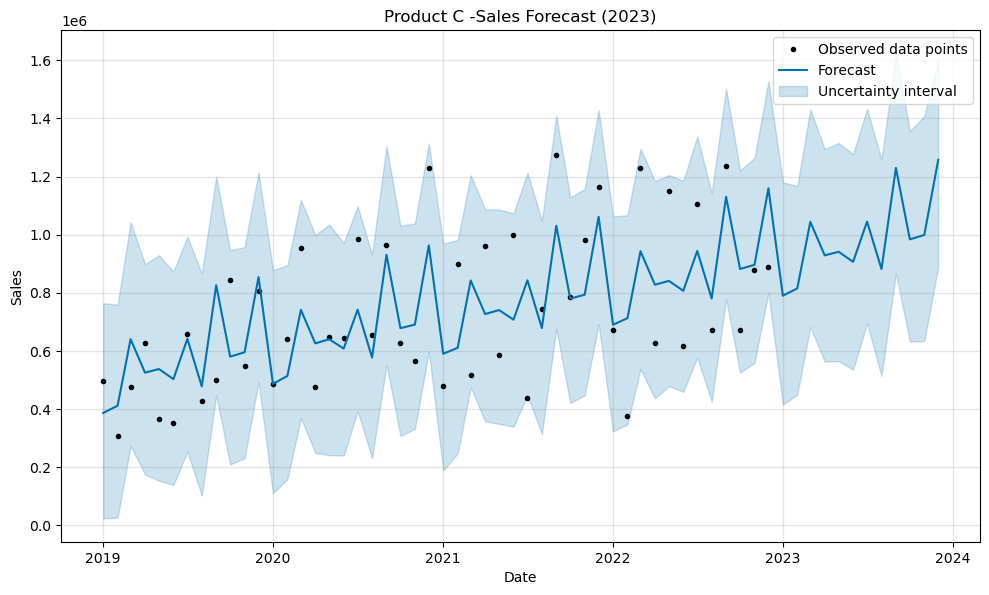

In [22]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product C -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

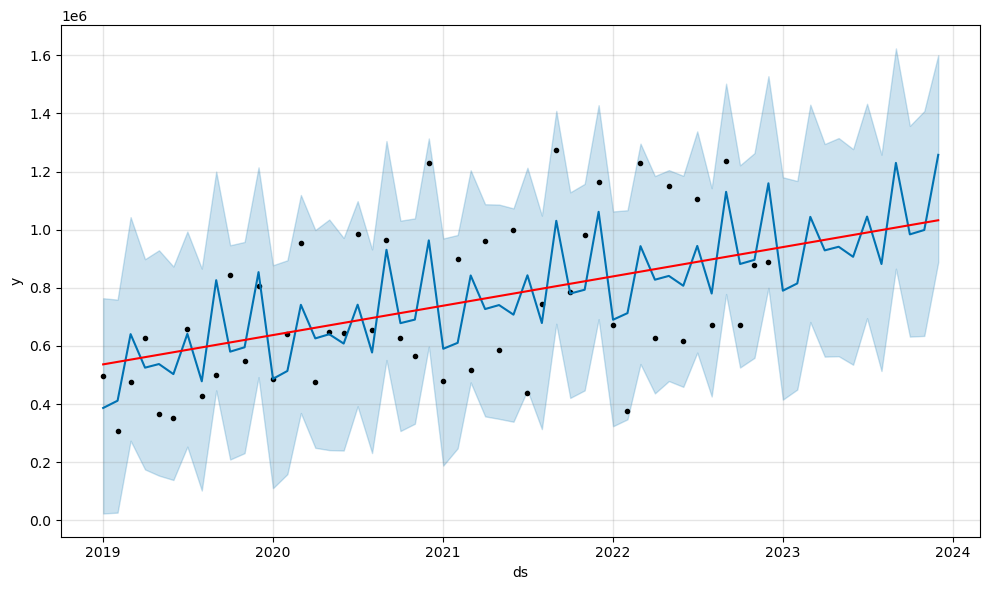

In [23]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

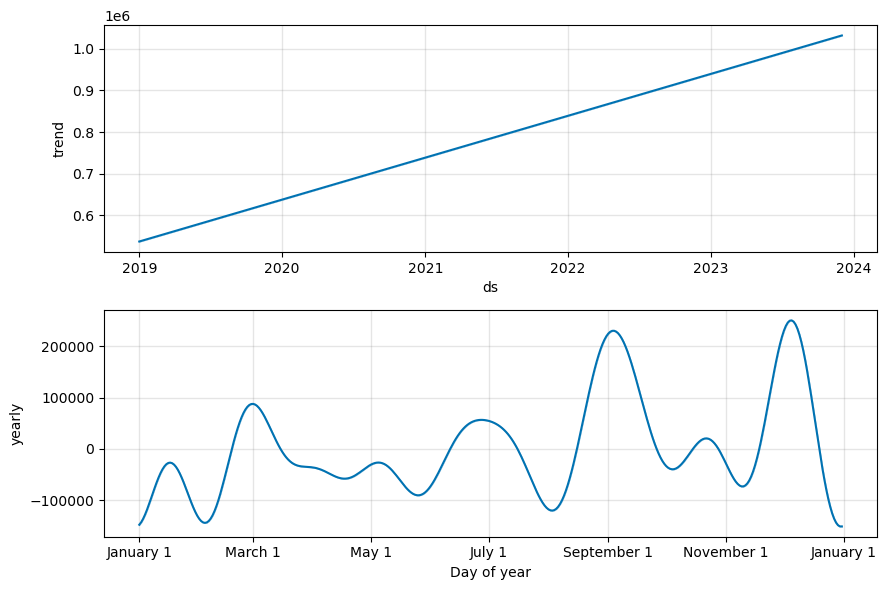

In [24]:
fig2 = model.plot_components(forecast)

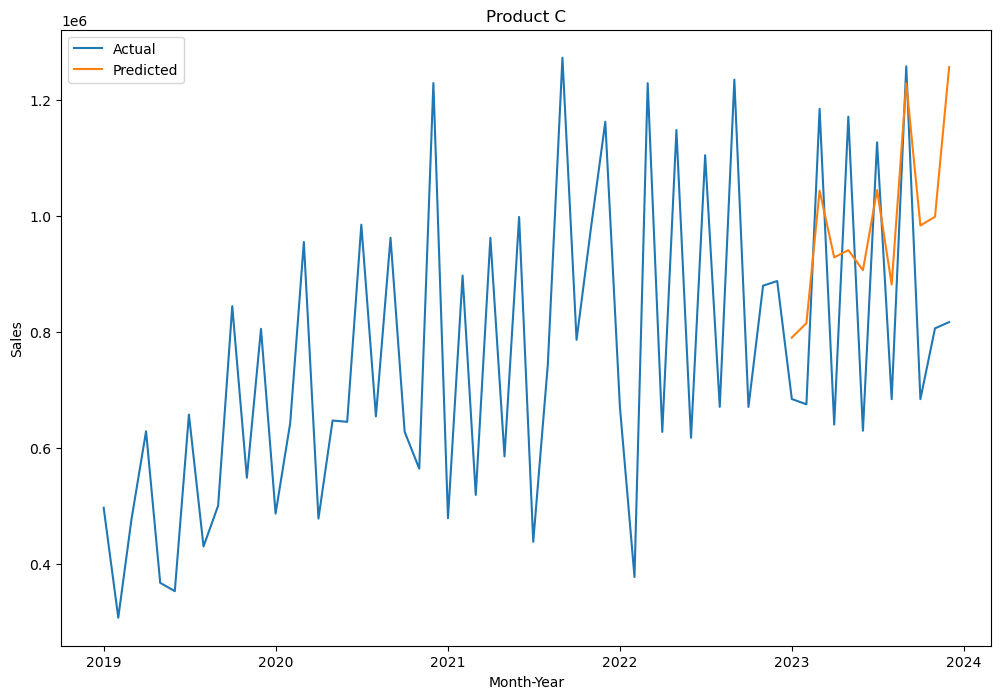

In [25]:
# Reset index of sales_b DataFrame
sales_c_reset_index = sales_c.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_c_reset_index['ds'], sales_c_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product C')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [26]:
#model evaluation

In [27]:
pred=forecasted_df['yhat']
test_df=test['y']

In [28]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 202195.573
MAPE - FB PROPHET: 0.264
MSE - FB PROPHET: 52674793894.369
RMSE - FB PROPHET: 229509.899


In [28]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [29]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [30]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse           rmse            mae      mape     mdape  \
0   31 days  1.133751e+10  106477.729372  106477.729372  0.158742  0.158742   
1   62 days  2.760881e+11  525440.846623  525440.846623  1.394515  1.394515   
2   90 days  8.663913e+10  294345.255488  294345.255488  0.239376  0.239376   
3  121 days  1.220490e+11  349355.173951  349355.173951  0.556852  0.556852   
4  151 days  1.031455e+11  321162.776642  321162.776642  0.279567  0.279567   
5  182 days  1.130841e+11  336279.854026  336279.854026  0.544972  0.544972   
6  212 days  1.580762e+10  125728.354623  125728.354623  0.113750  0.113750   
7  243 days  5.260182e+10  229350.858317  229350.858317  0.342047  0.342047   
8  274 days  2.615744e+09   51144.340216   51144.340216  0.041388  0.041388   
9  304 days  1.327137e+11  364298.878735  364298.878735  0.543305  0.543305   
10 335 days  1.118941e+10  105780.012001  105780.012001  0.120215  0.120215   
11 365 days  1.991995e+11  446317.698136  446317.698136  0.502658  0.502658   

       smape  coverage  
0   0.147069       1.0  
1   0.821629       0.0  
2   0.271921       1.0  
3   0.435576       0.0  
4   0.324997       0.0  
5   0.428273       0.0  
6   0.120609       1.0  
7   0.292092       1.0  
8   0.042262       1.0  
9   0.427243       0.0  
10  0.113399       1.0  
11  0.401699       0.0

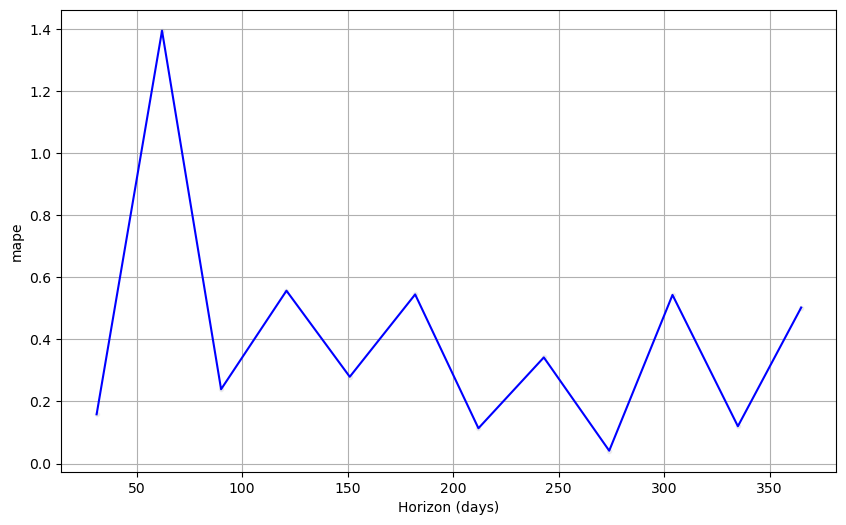

In [31]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [32]:
test_df

48     684175
49     675038
50    1185258
51     639923
52    1171761
53     629400
54    1127413
55     683935
56    1258717
57     683935
58     806218
59     816978
Name: y, dtype: int64

In [33]:
pred

48    7.901947e+05
49    8.151415e+05
50    1.044079e+06
51    9.288241e+05
52    9.412238e+05
53    9.066149e+05
54    1.045073e+06
55    8.818582e+05
56    1.229615e+06
57    9.838538e+05
58    9.989307e+05
59    1.257373e+06
Name: yhat, dtype: float64

# FORECASTING

In [34]:
model_forecast = Prophet(changepoint_prior_scale=0.100, seasonality_prior_scale=0.10, seasonality_mode='additive',interval_width=0.95)

In [35]:
model_forecast.fit(sales_c)

12:36:30 - cmdstanpy - INFO - Chain [1] start processing
12:36:31 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=12, freq='MS')  # 12 months in 2024

In [37]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [38]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

In [39]:
forecasted_f_df

ds          yhat     yhat_lower    yhat_upper
60 2024-01-01  7.978755e+05  417634.858534  1.157804e+06
61 2024-02-01  8.177805e+05  435092.116431  1.210632e+06
62 2024-03-01  1.098583e+06  719345.650403  1.459308e+06
63 2024-04-01  9.028088e+05  539944.511325  1.269565e+06
64 2024-05-01  1.012908e+06  661778.432672  1.385725e+06
65 2024-06-01  8.865147e+05  527041.654881  1.261504e+06
66 2024-07-01  1.085297e+06  712637.131396  1.440603e+06
67 2024-08-01  8.689768e+05  487525.719424  1.267697e+06
68 2024-09-01  1.264238e+06  915515.494584  1.649592e+06
69 2024-10-01  9.518590e+05  616433.463312  1.320525e+06
70 2024-11-01  9.837022e+05  615391.733871  1.329554e+06
71 2024-12-01  1.209943e+06  839923.031809  1.578004e+06

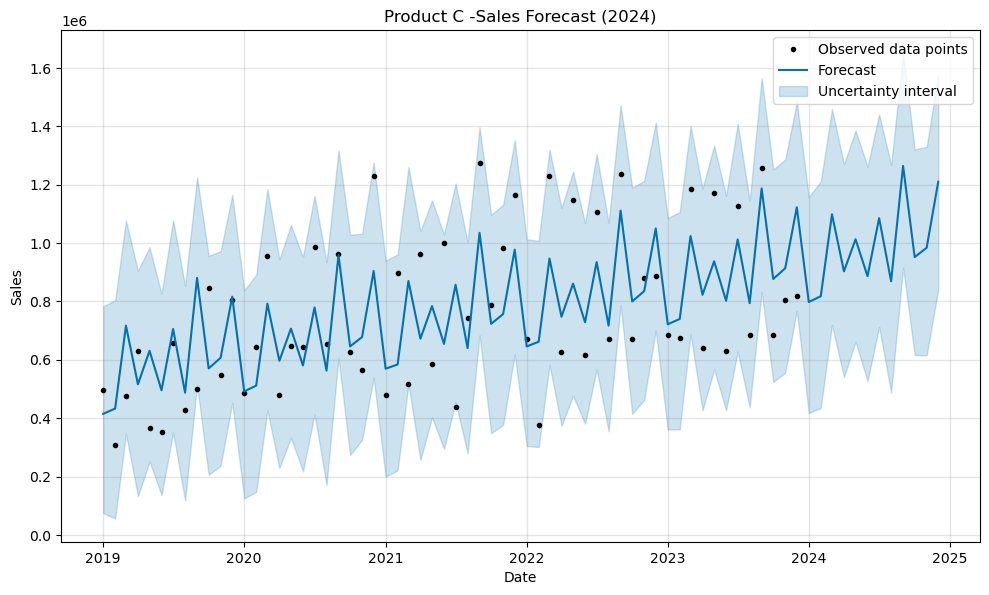

In [40]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product C -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [41]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [42]:
plot_components_plotly(model_forecast, forecast_f)